In [18]:
import json
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
from names_dataset import NameDataset
from tqdm import tqdm
from spacy.tokenizer import Tokenizer
import spacy
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)
# nlp = spacy.load("en_core_web_sm")
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")
ner_model = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

### Pre-Note
Token labels are presented in BIO (Beginning, Inner, Outer) format. The PII type is prefixed with “B-” when it is the beginning of an entity. If the token is a continuation of an entity, it is prefixed with “I-”. Tokens that are not PII are labeled “O”.

**Model idea** Lets instead of using the predefined token space, we define a new one without BIO definition, but where we concat tokens that are part of the same entity. We can then afterwards use SpaCy tokenizer to reverse the changes we made and get the labels.

In [21]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [22]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [23]:
labels = df.labels.explode().reset_index(drop=True)
labels_vc = labels.value_counts()
labels_vc

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

In [24]:
# Convert labels to binary, if the label is "O" then it is 0, otherwise it is 1
for i in range(len(df)):
    df.labels[i] = [1 if x != "O" else 0 for x in df.labels[i]]

In [25]:
df.labels[:10]

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...
1    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
5    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
6    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...
8    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
9    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: labels, dtype: object

## Model Definition
We will attempt to create the simplest model possible. The model will evaluate each token and pass it through a couple functions to evaluate it. If one of the functions returns true, the token will be considered a keyword. The model will then return the keyword and the index of the token in the input string.

### Model Functions
- **email** This function will use regex to identify if the token is an email address.
- **phone_num** This function will use regex to identify if the token is a phone number.
- **address** This function will use regex to identify if the token is an address.
- **username** This function will use a word embedding model to identify if the token is a common word and if not then we flag it as a username.
- **personal_id** This function will use regex to identify if the token is a personal id.


In [15]:
names = NameDataset()

**To do**
Maybe we could make some more features for capitalised words etc.

In [36]:
import re

def tokenizer(text):
    # Remove excessive line breaks or spaces
    text = re.sub('(\r\n){2,}', ' ', text)
    
    # Convert the text to lowercase and split into tokens
    tokens = text.lower().split(" ")
    
    return tokens

class PiiModel:
    def __init__(self, text: str = None, 
                 names_dataset = None, tokens: list = None, 
                 significant_tokens: dict = None, 
                 dataframe: pd.DataFrame = None, full_text: str = None):
        self.text = text
        self.names = names_dataset
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.name_rank_threhsold = 1500
        self.country_threshold = 0.01
        self.significant_tokens = significant_tokens
        self.feature_df = pd.DataFrame()
        self.input_df = dataframe
        self.full_text = full_text
        pass
    
    def get_firstname(self, name: str) -> bool:
        found_name = self.names.first_names.get(name.capitalize())

        if not found_name:
            return False
        country = found_name["country"]
        # If any of the countries has a higher percentage than the threshold and the rank is lower than the threshold
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False

    
    def get_lastname(self, lastname: str) -> bool:
        found_name = self.names.last_names.get(lastname.capitalize())
        # we check if the max country is higher than a threshold then we say it is a valid name
        if not found_name:
            return False
        country = found_name["country"]
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False
    
    def get_email_regex(self):
        return r'[\w\.-]+@[\w\.-]+'
    
    def get_phone_number_regex(self):
        return r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    
    def get_address_regex(self):
        return r'\d{1,5}\s\w.\s(\b\w*\b\s){1,2}\w*\.'
    
    def get_personal_id_regex(self):
        return r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
    
    def get_url_personal_regex(self):
        return r'https?://[\w\.-]+'
    
    def numb_percent(self, text: str) -> float:
        return sum(c.isdigit() for c in text) / len(text)
    
    def word_length(self, text: str) -> int:
        return len(text)
    
    def is_punctuationmark(self, text: str) -> bool:
        return text in [".", ",", "!", "?", ";", ":"]
    
    def stop_words(self, text: str) -> bool:
        return text in nlp.Defaults.stop_words
    
    def capitalize(self, text: str) -> bool:
        return text[0].strip().isupper()
    
    def NER_ingest(self, text: str):
        return ner_model(text)

    def contextual_ner_person(self, text: str) -> bool:
        return text in list(self.NER_persons)
    
    def contextual_ner_location(self, text: str) -> bool:
        return text in (self.NER_locations)
    
    def check_preceding_contextual_tokens(self, index, label):
        # Extract relevant tokens directly, avoiding repeated DataFrame row access
        start_index = max(0, index-2)
        tokens_to_check = self.feature_df['token'][start_index:index]
        
        # Get the set of significant tokens for the label, defaulting to an empty set if not found
        significant_tokens_set = self.significant_tokens.get(label, set())
        
        # Check if any of the tokens to check are in the significant tokens set
        return any(token in significant_tokens_set for token in tokens_to_check)

    
    def build_df(self, text: str = "", tokens: list = None, labels: list = None) -> pd.DataFrame:
        token_indices = self.tokens
        if not self.tokens and text != "":
            token_indices = self.tokenizer(text)
            self.tokens = token_indices
        if tokens:
            token_indices = tokens
        elif self.input_df is not None:
            token_indices = self.input_df["tokens"]
        self.feature_df["token"] = token_indices

        self.feature_df['labels'] = labels
        return None

    def build_features(self) -> list[tuple[int, str]]:
        # Computing Features
        self.feature_df['first_name'] = self.feature_df['token'].apply(self.get_firstname)
        self.feature_df['last_name'] = self.feature_df['token'].apply(self.get_lastname)
        self.feature_df['email'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_email_regex(), x)))
        self.feature_df['phone_number'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_phone_number_regex(), x)))
        self.feature_df['address'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_address_regex(), x)))
        self.feature_df['personal_id'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_personal_id_regex(), x)))
        self.feature_df['url'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_url_personal_regex(), x)))
        self.feature_df['capitalized'] = self.feature_df['token'].apply(lambda x: self.capitalize(x))
        self.feature_df['numb_percent'] = self.feature_df['token'].apply(self.numb_percent)
        self.feature_df['word_length'] = self.feature_df['token'].apply(self.word_length)
        self.feature_df['norm_index'] = self.feature_df.index / len(self.feature_df)
        self.feature_df['is_punctuation'] = self.feature_df['token'].apply(self.is_punctuationmark)
        self.feature_df['stop_word'] = self.feature_df['token'].apply(self.stop_words)

        ingested = self.NER_ingest(self.full_text)

        # We genralise this as we are not interest in specific entities
        self.NER_entities = pd.Series([entity['word'] for entity in ingested]).explode().reset_index(drop=True)

        self.feature_df['contextual_ner'] = self.feature_df['token'].apply(lambda x: x in list(self.NER_entities))

        # Window
        for i in range(1, 6):
            self.feature_df[f'r_neighboured_email_{i}'] = self.feature_df['email'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_email_{i}'] = self.feature_df['email'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_address_{i}'] = self.feature_df['address'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_address_{i}'] = self.feature_df['address'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_url_{i}'] = self.feature_df['url'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_url_{i}'] = self.feature_df['url'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_{i}'] = self.feature_df['contextual_ner'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_{i}'] = self.feature_df['contextual_ner'].shift(i).fillna(False)


        if self.input_df is not None:
            self.feature_df["text_index"] = self.input_df.text_index
        # Add a new feature for each label based on contextual tokens
        for label in self.significant_tokens.keys():
            feature_name = f'{label}_contextual_presence'
            self.feature_df[feature_name] = [self.check_preceding_contextual_tokens(i, label) for i in range(len(self.feature_df))]


        return None


## Data building


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_split = df.iloc[:500]

X_train, X_test, y_train, y_test = train_test_split(df_split, 
                                                    df_split.labels, 
                                                    test_size=0.33, 
                                                    random_state=42)

# Preceeding Words analysis on Xtrain:

In [30]:
dfs_analysis = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names)
    model.build_df(tokens=tokens, labels=labels)
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_analysis.append(model.feature_df)

X_analysis = pd.concat(dfs_analysis, axis=0)
X_analysis.fillna(0, inplace=True)


100%|██████████| 335/335 [00:00<00:00, 2228.33it/s]


In [31]:
_analysis_df = X_analysis[['token', 'labels']].reset_index()

In [32]:
_analysis_df.labels.unique()

array([0, 1])

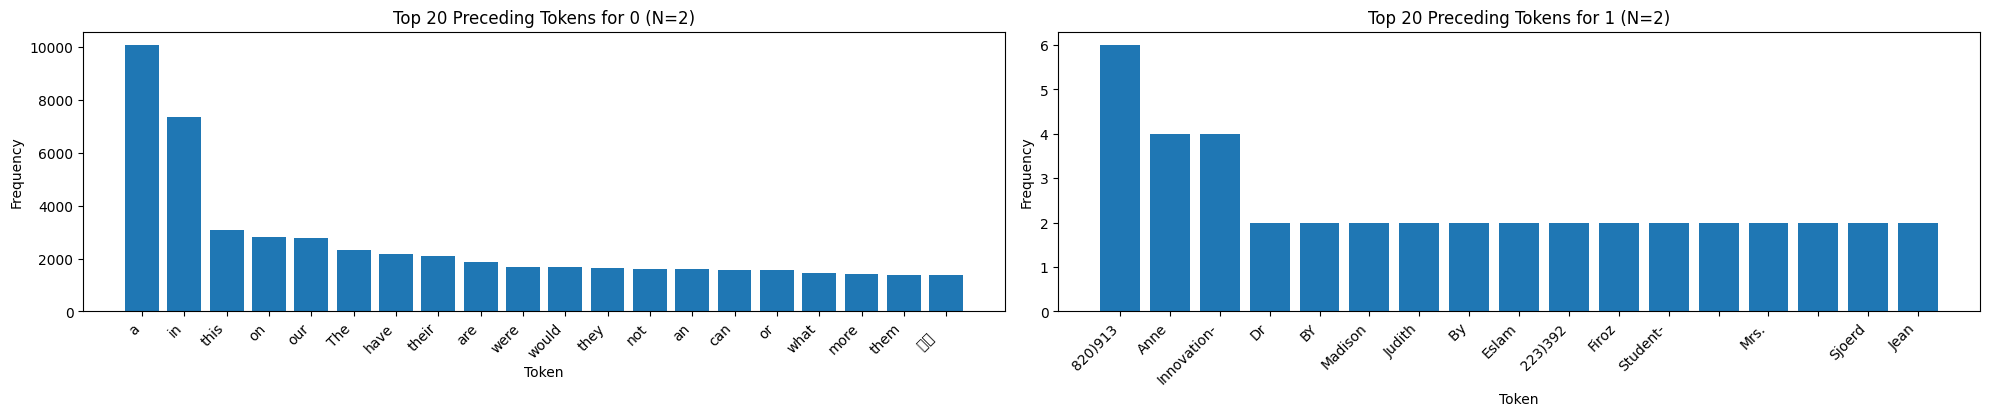

In [34]:
def get_preceding_tokens(row_index, N, dataframe):
    # Calculate the start index to avoid negative indexing
    start_index = max(0, row_index - N)
    # Extract preceding N tokens, if the row_index is not at the very beginning
    if start_index < row_index:
        return dataframe.iloc[start_index:row_index]['token'].tolist()
    else:
        return []


N = 2  # Example: Look 5 tokens back
labels_of_interest = [0, 1]

# Initialize a dictionary to hold token frequencies for each label
token_frequencies_by_label = {label: {} for label in labels_of_interest}

for label in labels_of_interest:
    # Filter rows for the specific label
    label_indices = _analysis_df[_analysis_df['labels'] == label].index
    
    # Collect preceding tokens for each occurrence of the label
    for index in label_indices:
        preceding_tokens = get_preceding_tokens(index, N, _analysis_df)
        for token in preceding_tokens:
            if token in token_frequencies_by_label[label]:
                token_frequencies_by_label[label][token] += 1
            else:
                token_frequencies_by_label[label][token] = 1


from collections import defaultdict

# This dictionary will count the occurrences of each token across labels
token_occurrences_across_labels = defaultdict(int)

# Count occurrences of each token across different labels
for label, frequencies in token_frequencies_by_label.items():
    for token in frequencies.keys():
        token_occurrences_across_labels[token] += 1

# Identify tokens that appear in more than one label's frequency dictionary
common_tokens = {token for token, count in token_occurrences_across_labels.items() if count > 1}


# Remove common tokens from each label's frequency dictionary
filtered_token_frequencies_by_label = {
    label: {token: frequency for token, frequency in frequencies.items() if token not in common_tokens}
    for label, frequencies in token_frequencies_by_label.items()
}


plt.figure(figsize=(20, 15))

for i, (label, frequencies) in enumerate(filtered_token_frequencies_by_label.items(), 1):
    # Sort the frequencies dictionary by value and get the top 20 tokens
    try:
        top_tokens = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
        tokens, counts = zip(*top_tokens)  # Unzip the token-count pairs
        
        # Plot
        plt.subplot(4, 2, i)  # Adjust grid size based on the number of labels
        plt.bar(tokens, counts)
        plt.title(f'Top 20 Preceding Tokens for {label} (N={N})')
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Frequency')
        plt.xlabel('Token')
    except:
        pass
    
plt.tight_layout()
plt.show()

# Creating DFs

In [37]:
dfs_train = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names, significant_tokens=token_frequencies_by_label, full_text=X_train.full_text.iloc[i])
    model.build_df(tokens=tokens, labels=labels)
    model.build_features()
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_train.append(model.feature_df)

X_train = pd.concat(dfs_train, axis=0)
X_train.fillna(0, inplace=True)


100%|██████████| 335/335 [01:17<00:00,  4.33it/s]


In [38]:
dfs_test = []

for i in tqdm(range(X_test.shape[0])):
    tokens, labels = X_test.tokens.iloc[i], y_test.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names, significant_tokens=token_frequencies_by_label, full_text=X_test.full_text.iloc[i])
    model.build_df(tokens=tokens, labels=labels)
    model.build_features()
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_test.append(model.feature_df)

X_test = pd.concat(dfs_test, axis=0)
X_test.fillna(0, inplace=True)


100%|██████████| 165/165 [00:36<00:00,  4.51it/s]


In [57]:
# Find unique entries in y_test
pd.Series(y_test.explode()).value_counts()

labels
0    134408
1       490
Name: count, dtype: int64

In [49]:
X_train.drop(columns=["token", "labels"])

,first_name,last_name,email,phone_number,address,personal_id,url,capitalized,numb_percent,word_length,...,r_neighboured_word_length_5,l_neighboured_word_length_5,r_neighboured_first_name_5,l_neighboured_first_name_5,r_neighboured_last_name_5,l_neighboured_last_name_5,r_neighboured_contextual_ner_5,l_neighboured_contextual_ner_5,0_contextual_presence,1_contextual_presence
0,False,False,False,False,False,False,False,True,0.0,6,...,5.0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,0.0,8,...,10.0,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,0.0,3,...,2.0,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,True,0.0,10,...,9.0,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,0.0,1,...,2.0,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,False,False,False,False,False,False,False,False,0.0,4,...,False,1.0,False,False,False,False,False,False,True,True
538,True,True,False,False,False,False,False,False,0.0,2,...,False,3.0,False,True,False,True,False,False,True,True
539,False,False,False,False,False,False,False,False,0.0,11,...,False,1.0,False,False,False,False,False,False,True,True
540,False,False,False,False,False,False,False,False,0.0,1,...,False,5.0,False,False,False,False,False,False,True,True


## Modelling
We will use the XGBoost model to classify the tokens.

In [50]:
def fx_score(y_pred, y_true, beta=1):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return (1+beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

In [52]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train.drop(columns=["token", "labels"]), y_train.explode().astype('int'))

RandomForestClassifier(n_jobs=-1)

In [54]:
model.score(X_test.drop(columns=["token", "labels"]), y_test.explode().astype('int'))

0.9985470503639787

In [55]:
predictions = model.predict(X_test.drop(columns=["token", "labels"]))

In [81]:
X_test[predictions == 1]["labels"].value_counts()

labels
1    306
0     12
Name: count, dtype: int64

In [82]:
X_test[predictions == 0]["labels"].value_counts()

labels
0    134396
1       184
Name: count, dtype: int64

In [56]:
pd.Series(predictions).value_counts()

0    134580
1       318
Name: count, dtype: int64

In [58]:
pd.Series(y_test.explode()).value_counts()

labels
0    134408
1       490
Name: count, dtype: int64

In [59]:
df_results = pd.DataFrame({"predictions": pd.Series(predictions).reset_index(drop=True), 
                           "labels": y_test.explode().reset_index(drop=True), 
                           "tokens": X_test.token.explode().reset_index(drop=True)})
df_results.head()

,predictions,labels,tokens
0,0,0,Student
1,0,0,Name
2,0,0,:
3,1,1,Rania
4,1,1,Mohammed


In [60]:
accuracy = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O")) & 
    (df_results['predictions'] == df_results['labels'])
].shape[0] / df_results[(df_results['predictions'] != "O") | (df_results['labels'] != "O")].shape[0]

In [61]:
accuracy

0.9985470503639787

In [62]:
df_results['predictions'][df_results['predictions'] != "O"]

0         0
1         0
2         0
3         1
4         1
         ..
134893    0
134894    0
134895    0
134896    0
134897    0
Name: predictions, Length: 134898, dtype: int64

In [63]:
non_O_rows = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))
]
non_O_rows

,predictions,labels,tokens
0,0,0,Student
1,0,0,Name
2,0,0,:
3,1,1,Rania
4,1,1,Mohammed
...,...,...,...
134893,0,0,from
134894,0,0,specific
134895,0,0,employees
134896,0,0,.


In [66]:
fx_score(df_results['predictions'].astype('int'), df_results['labels'].astype('int'), 5)

0.9985452667701841

**Prediction Pairs** 

In [73]:
df_results.value_counts()

predictions  labels  tokens               
0            0       the                      6435
                                              5995
                     .                        4479
                     to                       4279
                     ,                        4252
                                              ... 
                     digitisation                1
                     digitalize                  1
                     digitalization              1
                     digitalisation              1
1            1       vmartinez@hotmail.com       1
Name: count, Length: 9678, dtype: int64

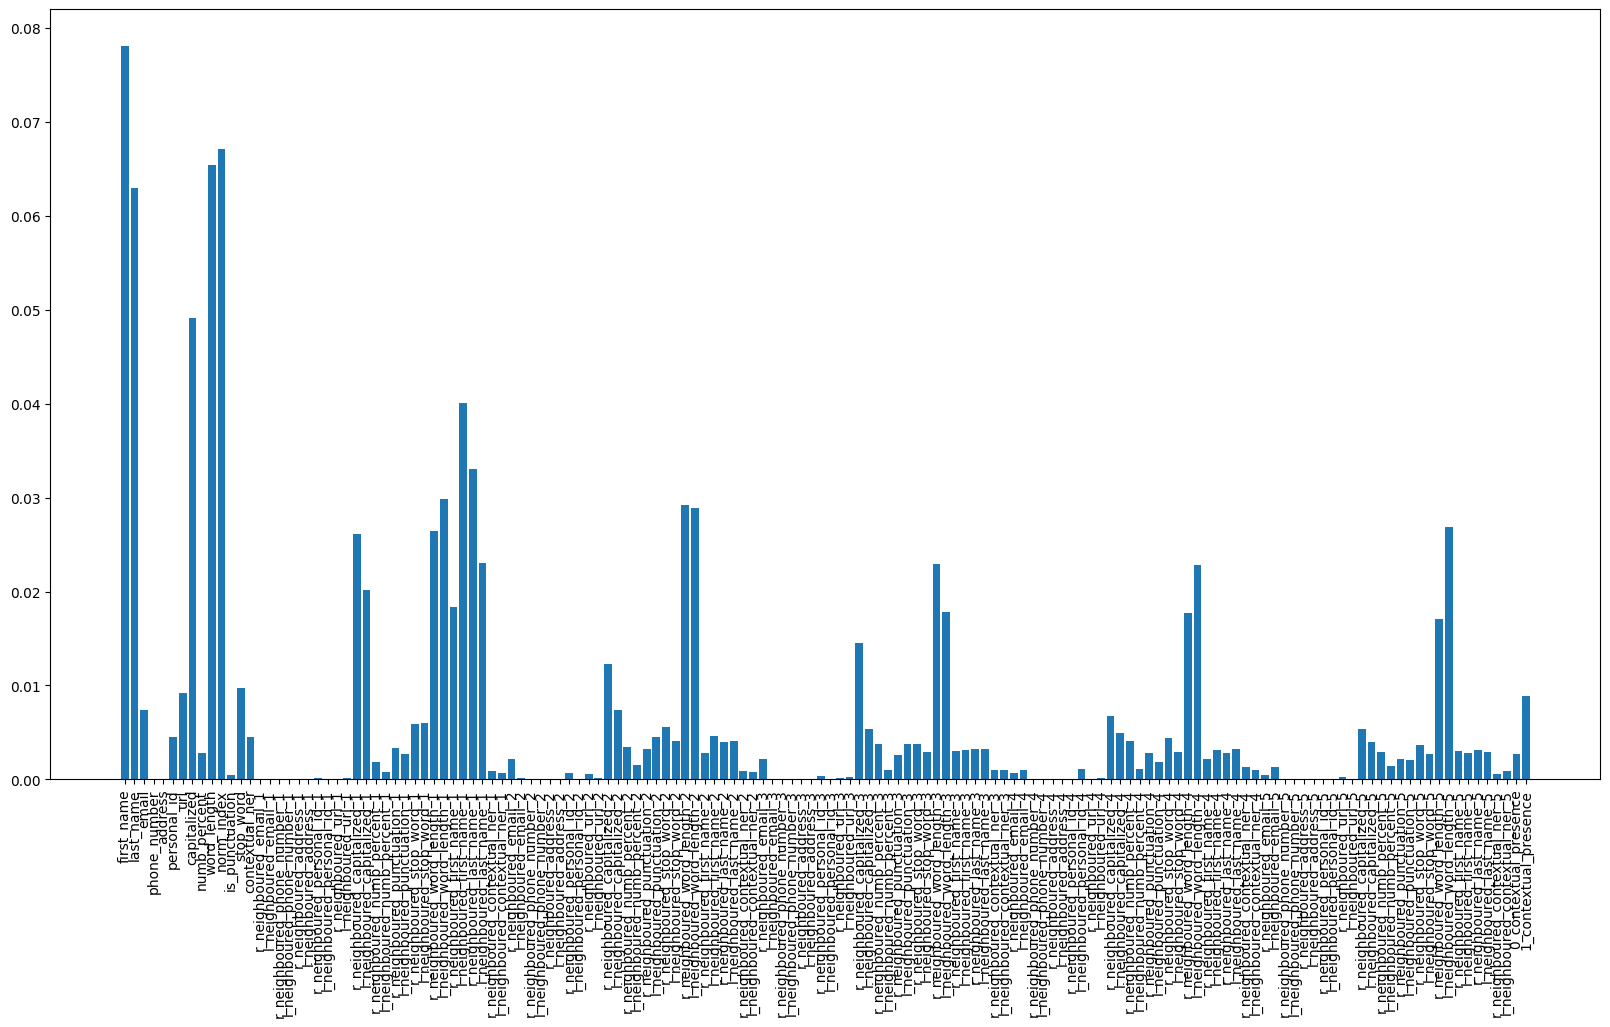

In [72]:
# print feature importance
importances = model.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(X_train.drop(columns=["token", "labels"]).columns, importances)
plt.xticks(rotation=90)
plt.show();